Complete notebook available at: https://github.com/ai4up/ufo-prediction/blob/main/demo/demo.ipynb

## Motivation

Building attributes such as building height, type, and construction year are not available for all buildings in EUBUCCO. However, for many prospective use cases of the dataset, such as energy modeling, the building attributes are of high importance. This notebook shows how the available building footprints can be used to estimate missing building attributes with supervised machine learning.

In [1]:
# -.-|m { input: false }

# standard libs
import os
import sys
import logging

# project lib
PROJECT_SRC_PATH = os.path.join( '/workspace/workspace/ufo-prediction', 'src-RCA-UFO')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison
import preprocessing as pp
import dataset
import utils

# external libs
import numpy as np
import pandas as pd
import geopandas as gpd
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-gme53mdx because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# -.-|m { input: false }

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

## Data

Demo sample of ~20k buildings for Spain, ~50k for France, and 170k for the Netherlands. All 117 urban form features, lat lon, as well as some auxiliary attributes like city name, neighborhood, building type, etc. are included.

The demo samples are stored using Git Large File Storage (LFS). To download them explicitly use:

In [3]:
path_data_RCA = os.path.join(dataset.DATA_DIR, 'rca-ufo-merge.csv')
df = pd.read_csv(path_data_RCA, encoding='latin1')

## Prediction

In [4]:
xgb_model_params = {'tree_method': 'hist'}
xgb_hyperparams = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

### Regression

Here we deliberately predict "age_right" the age variable from EUBUCCO, given that for NLD it is 100% available and therefore has higher coverage than YearBlt from RCA. YearBlt and age_right have a correlation of 0.6 To make results more comparable, in the RCA only version, I revert to using YearBlt instead of YearBlt_new2, given that YearBlt_new2 has a correlation of only 0.22 with age_right from EUBUCCO.

2024-01-19 17:19:41,027 | INFO : Dataset length: 3982
2024-01-19 17:19:41,033 | INFO : Dataset allocated memory: 6 MB
2024-01-19 17:19:41,039 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-eb1b8002.abort.
2024-01-19 17:19:41,040 | INFO : Dataset standard deviation: 65.99180941860475
2024-01-19 17:19:41,041 | INFO : Dataset mean age: 1972.1770467101958
2024-01-19 17:19:41,041 | INFO : Training dataset length: 3185
2024-01-19 17:19:41,041 | INFO : Test dataset length: 797


2024-01-19 17:19:41,129 | INFO : Features selected are: ['PropertyKey_ID', 'Deal_id', 'Property_id', 'Status_tx', 'TransType_tx', 'country', 'Main Type', 'SubType', 'DealQualifyer', 'Excess_Land_Potential_fg', 'Lat_nb', 'Lon_nb', 'BuyerAssumedDebt', 'CMBS_fg', 'Deal5M_fg', 'Deal10M_fg', 'EligibleForVolume_fg', 'EligibleForPPU_fg', 'EligibleForCapRates_fg', 'Active_fg', 'year', 'Property_nb', 'Price', 'StatusPriceAdjustedUSD_amt', 'PriceEuro', 'StatusPriceAdjustedEUR_amt', 'BuyerObjective', 'BuyerCapGroup1', 'BuyerCapType1', 'PropertyName', 'Region', 'State_cd', 'RCA_Metros_tx', 'SellerCapGroup1', 'SellerCapType1', 'County_nm', 'RCA_Markets_tx', 'Leaseback_fg', 'City_tx', 'CBD_fg', 'PSF/PPU', 'Zip_cd', 'BuyerCountry', 'BuyerName1', 'Address_tx', 'SellerName1', 'SellerCountry', 'Tenancy_tx', 'SqFt_nb', 'NumberBldgs_nb', 'NumberFloors_nb', 'residential_type', 'dist_to_closest_int', 'av_footprint_area_within_buffer_100', 'street_betweeness_global_max_within_buffer_500', 'av_elongation_with

Applying categorical_to_int_byList to variables: ['Status_tx', 'TransType_tx', 'country', 'Main Type', 'SubType', 'DealQualifyer', 'Excess_Land_Potential_fg', 'CMBS_fg', 'Deal5M_fg', 'Deal10M_fg', 'EligibleForVolume_fg', 'EligibleForPPU_fg', 'EligibleForCapRates_fg', 'Active_fg', 'BuyerObjective', 'BuyerCapGroup1', 'BuyerCapType1', 'PropertyName', 'Region', 'State_cd', 'RCA_Metros_tx', 'SellerCapGroup1', 'SellerCapType1', 'County_nm', 'RCA_Markets_tx', 'Leaseback_fg', 'City_tx', 'CBD_fg', 'Zip_cd', 'BuyerCountry', 'BuyerName1', 'Address_tx', 'SellerName1', 'SellerCountry', 'Tenancy_tx', 'residential_type']
Applying convert_to_double_byList to variables: ['PropertyKey_ID', 'Deal_id', 'Property_id', 'Lat_nb', 'Lon_nb', 'BuyerAssumedDebt', 'year', 'Property_nb', 'Price', 'StatusPriceAdjustedUSD_amt', 'PriceEuro', 'StatusPriceAdjustedEUR_amt', 'PSF/PPU', 'SqFt_nb', 'NumberBldgs_nb', 'NumberFloors_nb', 'residential_type']


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
2024-01-19 17:19:42,308 | INFO : Energy need for heating in kWh/(m²a) R2: 0.2008
2024-01-19 17:19:42,309 | INFO : Energy need for heating in kWh/(m²a) MAPE: 0.2842
2024-01-19 17:19:42,309 | INFO : Energy need for heating in kWh/(m²a) MAE: 26.32
2024-01-19 17:19:42,310 | INFO : Energy need for heating in kWh/(m²a) RMSE: 39.04


MAE: 14.40 y
RMSE: 19.89 y
R2: 0.3828
Energy need for heating in kWh/(m²a) R2: 0.2008
Energy need for heating in kWh/(m²a) MAPE: 0.2842


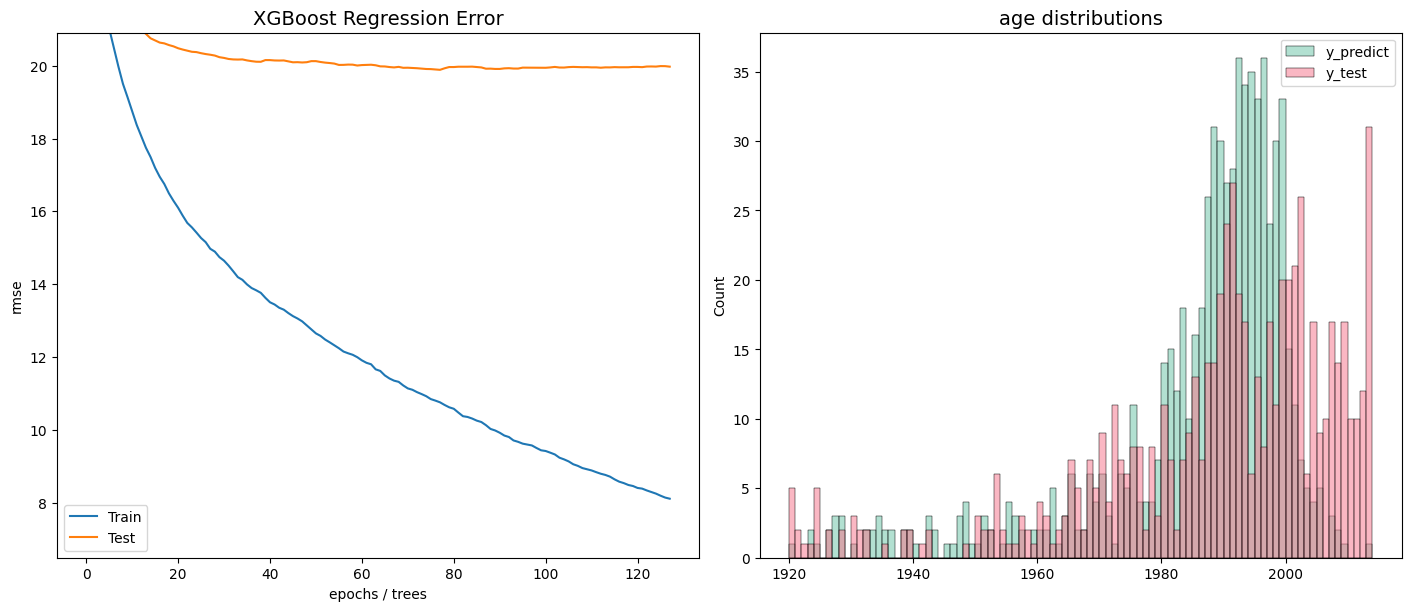

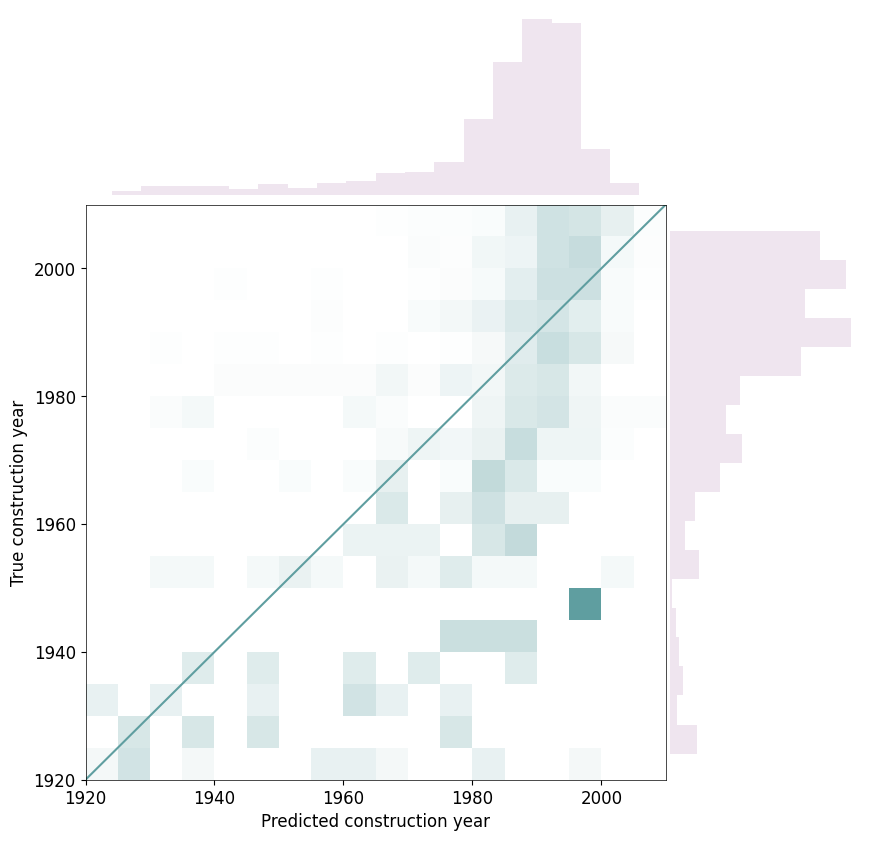

In [5]:
predictor = AgePredictor(
    model=XGBRegressor(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    early_stopping=True,
    hyperparameters=xgb_hyperparams,
    preprocessing_stages=[pp.remove_outliers, pp.categorical_to_int_byList, pp.convert_to_double_byList]
)

predictor.evaluate()


In [ ]:
def age_bins(y, bin_size=1):
    # lower bound inclusive
    min_age = math.floor(y[dataset.AGE_ATTRIBUTE].min())
    # upper bound inclusive for histogram plotting, exclusive for categorizing variables
    max_age = math.ceil(y[dataset.AGE_ATTRIBUTE].max())
    return list(range(min_age, max_age + 1))[0::bin_size]

In [14]:
import math
min_age = 1900
max_age = math.ceil(df[dataset.AGE_ATTRIBUTE].max())

Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.


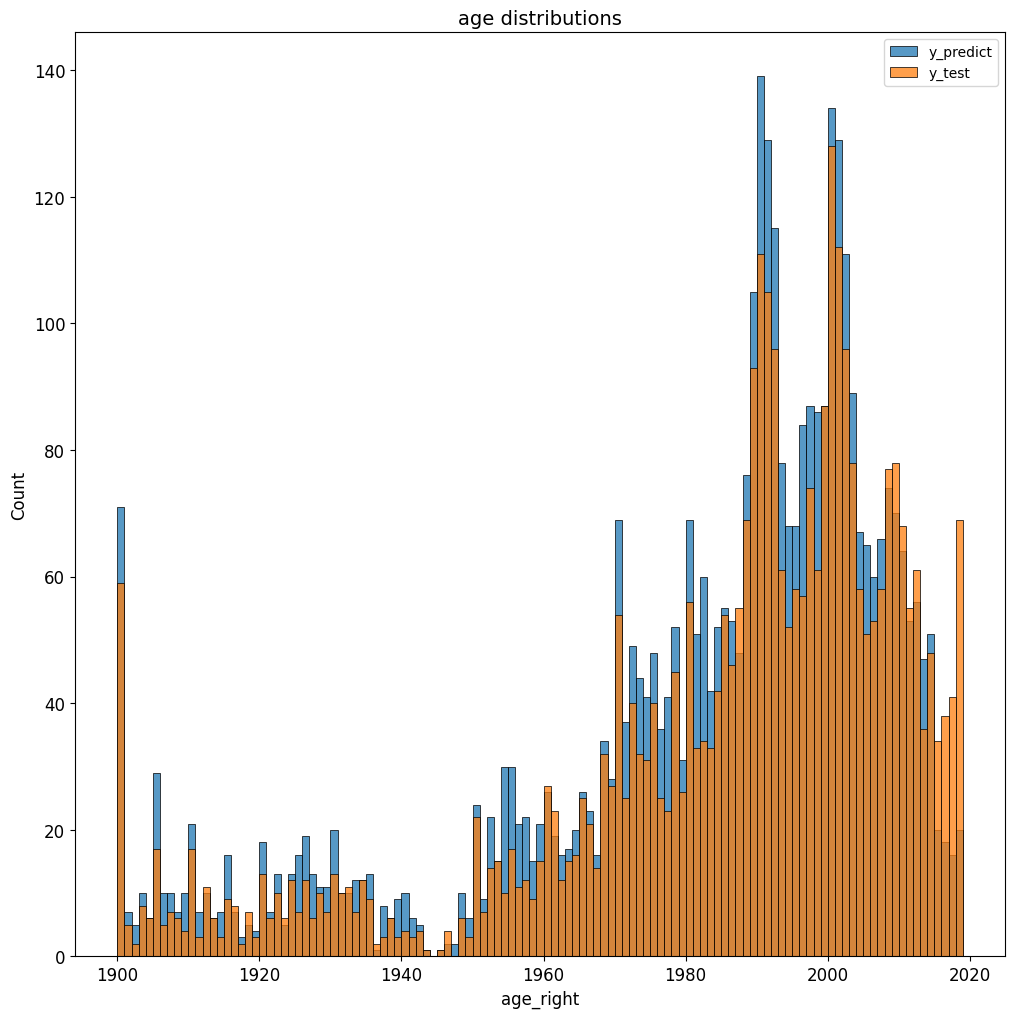

In [18]:
#YearBlt is y_test
visualizations.plot_histogram(df['YearBlt'], df['age_right'], bins=list(range(min_age, max_age + 1))[0::1])

In [40]:
from sklearn import metrics
df_filtered = df[df['YearBlt'].notna()]
print('MAE: {:.2f} y'.format(metrics.mean_absolute_error(df_filtered['age_right'], df_filtered['YearBlt'])))
print('RMSE: {:.2f} y'.format(np.sqrt(metrics.mean_squared_error(df_filtered['age_right'], df_filtered['YearBlt']))))
print('R2: {:.4f}'.format(metrics.r2_score(df_filtered['age_right'], df_filtered['YearBlt'])))


MAE: 27.27 y
RMSE: 118.00 y
R2: 0.3802


In [37]:
df_filtered['age_right']

4       1990.0
5       1997.0
6       1978.0
7       1986.0
10      2008.0
         ...  
4555    1981.0
4556    2002.0
4557    1965.0
4558    1989.0
4559    2007.0
Name: age_right, Length: 3982, dtype: float64

In [38]:
df_filtered['YearBlt']

4       1990.0
5       1998.0
6       1978.0
7       1991.0
10      2009.0
         ...  
4555    1981.0
4556    2002.0
4557    2020.0
4558    1989.0
4559    2007.0
Name: YearBlt, Length: 3982, dtype: float64

### Classification

2023-01-30 11:31:17,623 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2023-01-30 11:31:17,624 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']
2023-01-30 11:31:17,807 | INFO : Dataset length: 176319
2023-01-30 11:31:17,813 | INFO : Dataset allocated memory: 184 MB
2023-01-30 11:31:18,000 | INFO : No abort signal received. Continuing... To abort please create /Users/fnachtigall/workspace/ufo-prediction/metadata/local-fd77a0e5.abort.
2023-01-30 11:31:18,000 | INFO : Training dataset length: 141055
2023-01-30 11:31:18,001 | INFO : Test dataset length: 35264
2023-01-30 11:31:18,004 | INFO : Test cities: ['Apeldoorn' 'Groesbeek' 'Roggel en Neer' 'Dronten' 'Rijnwaarden'
 'Jacobswoude' 'IJsselstein' 'Dinxperlo' 'Kapelle' 'Renkum']
2023-01-30 11:31:18,362 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2021).
2023-01-30 11:31:18,516 | INFO : age a

Classification report:
               precision    recall  f1-score  support
1900-1964      0.751537  0.842825  0.794567     8850
1965-1974      0.875129  0.834151  0.854149     7133
1975-1991      0.904658  0.799159  0.848642     8798
1992-2005      0.852081  0.774682  0.811540     6209
2006-2014      0.595462  0.695315  0.641526     3095
2015-2021      0.496798  0.711664  0.585129      763
accuracy       0.801911  0.801911  0.801911        0
macro avg      0.745944  0.776299  0.755926    34848
weighted avg   0.813968  0.801911  0.805261    34848
Cohen’s kappa: 0.7501
Matthews correlation coefficient (MCC): 0.7513


FixedFormatter should only be used together with FixedLocator


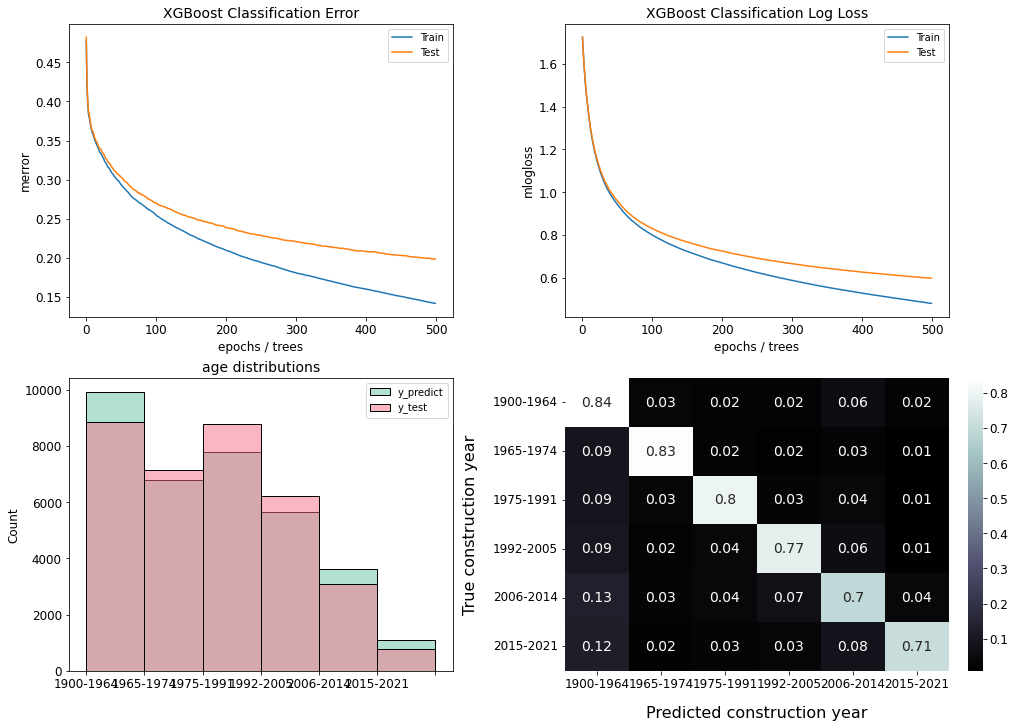

In [ ]:
tabula_nl_bins = [1900, 1965, 1975, 1992, 2006, 2015, 2022]
equally_sized_bins = (1900, 2020, 10)

classifier = AgeClassifier(
    model=XGBClassifier(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    mitigate_class_imbalance=True,
    # bin_config=equally_sized_bins,
    bins=tabula_nl_bins,
)
classifier.evaluate()

### Country and generalization comparison

The `AgePredictorComparison` faciliates comparisons between differently configured training runs, for example to compare the prediction performance between countries, cross-validation strategies, oversampling strategies or any other preprocessing steps.

In [ ]:
comparison_config = {
    'Spain': {'df': path_data_ESP},
    'France': {'df': path_data_FRA},
    'Netherlands': {'df': path_data_NLD},
}

grid_comparison_config = {
    'random-cv': {'cross_validation_split': pp.cross_validation},
    'neighborhood-cv': {'cross_validation_split': pp.neighborhood_cross_validation},
    'city-cv': {'cross_validation_split': pp.city_cross_validation},
}

comparison = AgePredictorComparison(
    exp_name='demo',
    model=XGBRegressor(**xgb_model_params),
    df=None,
    frac=0.5,
    cross_validation_split=None,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    compare_feature_importance=False,
    compare_classification_error=False,
    include_baseline=False,
    save_results=False,
    garbage_collect_after_training=True,
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)

results = comparison.evaluate()

2022-10-21 16:42:52,510 | INFO : Starting experiment Spain_random-cv...
2022-10-21 16:42:53,720 | INFO : Dataset length: 974
2022-10-21 16:42:53,726 | INFO : Dataset allocated memory: 1 MB
2022-10-21 16:42:53,731 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs/local-1eb3cae2.abort.
2022-10-21 16:42:53,731 | INFO : Dataset standard deviation: 45.78138305502198
2022-10-21 16:42:53,732 | INFO : Dataset mean age: 1950.3613963039015
2022-10-21 16:42:53,733 | INFO : Training dataset length: 779
2022-10-21 16:42:53,733 | INFO : Test dataset length: 195
2022-10-21 16:42:53,748 | INFO : Test dataset standard deviation after preprocessing: 34.49407581359104
2022-10-21 16:42:53,749 | INFO : Test dataset mean age after preprocessing: 1958.8352272727273
2022-10-21 16:42:53,749 | INFO : Training dataset length after preprocessing: 710
2022-10-21 16:42:53,749 | INFO : Test dataset length after preprocessing: 176
`early_stopping_rounds` in `

In [ ]:
results

,name,R2,R2_std,MAE,MAE_std,RMSE,RMSE_std,within_5_years,within_10_years,within_20_years,R2_seed_0
8,Netherlands_city-cv,0.135401,0.0,18.030643,0.0,23.598668,0.0,0.221385,0.392977,0.638903,0.135401
7,France_city-cv,0.187767,0.0,18.645831,0.0,23.772030,0.0,0.176875,0.345911,0.615315,0.187767
6,Spain_city-cv,0.197072,0.0,23.840955,0.0,29.563272,0.0,0.126411,0.247178,0.494357,0.197072
3,Spain_neighborhood-cv,0.198503,0.0,23.779078,0.0,29.536916,0.0,0.129797,0.247178,0.506772,0.198503
5,Netherlands_neighborhood-cv,0.304538,0.0,15.884060,0.0,21.164937,0.0,0.241489,0.444702,0.699700,0.304538
4,France_neighborhood-cv,0.330228,0.0,16.306574,0.0,21.586864,0.0,0.211348,0.408337,0.705209,0.330228
0,Spain_random-cv,0.363164,0.0,20.108252,0.0,26.328608,0.0,0.180587,0.355530,0.592551,0.363164
1,France_random-cv,0.511105,0.0,12.372172,0.0,18.443089,0.0,0.369564,0.593466,0.806340,0.511105
2,Netherlands_random-cv,0.575725,0.0,10.203823,0.0,16.531180,0.0,0.525335,0.695626,0.827052,0.575725
